<a href="https://colab.research.google.com/github/pritika-vig/MLHC-AgentBasedROI/blob/main/cancer_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain openai pillow
!pip install anthropic
!pip install -U langchain-community
!pip install -U langchain-anthropic

In [ ]:
!apt-get install -y openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 1s (126 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 126332 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import getpass, os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")


ANTHROPIC_API_KEY: ··········


In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # optional for debugging


In [ ]:
#import json
import ast
from langchain.tools import tool
from PIL import Image as PILImage
from IPython.display import display
import openslide
import os

# Assuming you define logic for these functions below
@tool
def region_of_interest(thumbnail_path: str) -> list:
    """Analyzes a thumbnail and returns a list of coordinates to investigate."""
    # For now just display thumbnail to show we are accurately opening it.
    img = PILImage.open(thumbnail_path)
    display(img)  # 👈 this will show the image in Colab

    # return random coordinates
    return [(25, 240)]

@tool
def zoom(input: str) -> list:
    """Zooms into a WSI based on thumbnail coordinates and returns cropped patch paths."""
    input_dict = ast.literal_eval(input)  # ✅ parse the string to dict

    # ✅ use the parsed dict
    thumbnail_coords = input_dict["thumbnail_coords"]
    wsi_path = input_dict["wsi_path"]

    thumbnail_width = 1024
    thumbnail_height = 779
    patch_size = 512
    if not os.path.exists(wsi_path):
      raise FileNotFoundError(f"WSI file not found at: {wsi_path}")
    slide = openslide.OpenSlide(wsi_path)
    wsi_width, wsi_height = slide.dimensions

    scale_x = wsi_width / thumbnail_width
    scale_y = wsi_height / thumbnail_height

    patches = []
    for thumb_x, thumb_y in thumbnail_coords:
        center_x = int(thumb_x * scale_x)
        center_y = int(thumb_y * scale_y)

        half_size = patch_size // 2
        top_left_x = max(center_x - half_size, 0)
        top_left_y = max(center_y - half_size, 0)

        patch = slide.read_region((top_left_x, top_left_y), 0, (patch_size, patch_size))
        display(patch)  # Optional: shows patch in Colab
        patches.append(f"Patch at ({center_x}, {center_y})")

    return patches

@tool
def patch_classification(input: str) -> dict:
    """Classifies a list of patch paths as cancerous or not."""
    patch_paths = ast.literal_eval(input)  # 👈 converts "['Patch at (...)']" to a real list

    results = {}
    for path in patch_paths:
        results[path] = "likely cancer"

    return results


In [ ]:
from langchain_community.chat_models import ChatAnthropic
from langchain_anthropic import ChatAnthropic
from langchain.agents import initialize_agent, AgentType, Tool

llm = ChatAnthropic(model="claude-3-opus-20240229", temperature=0)

tools = [
    Tool.from_function(
        func=region_of_interest,
        name="region_of_interest",
        description="Takes a thumbnail image path and returns coordinates to inspect for cancer."
    ),
    Tool.from_function(
        func=zoom,
        name="zoom",
        description="Takes thumbnail coordinates and a WSI path, and returns zoomed patch image paths."
    ),
    Tool.from_function(
      func=patch_classification,
      name="patch_classification",
      description="Takes a stringified list of patch locations and returns classification results."
      )
]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)




> Entering new AgentExecutor chain...


Here is my attempt at analyzing the slide for cancer:

Thought: I should first use the region_of_interest tool to identify suspicious areas in the thumbnail image.

Action: region_of_interest
Action Input: /content/drive/My Drive/Colab Notebooks/Dataset/thumbnails/tumor_011.jpg

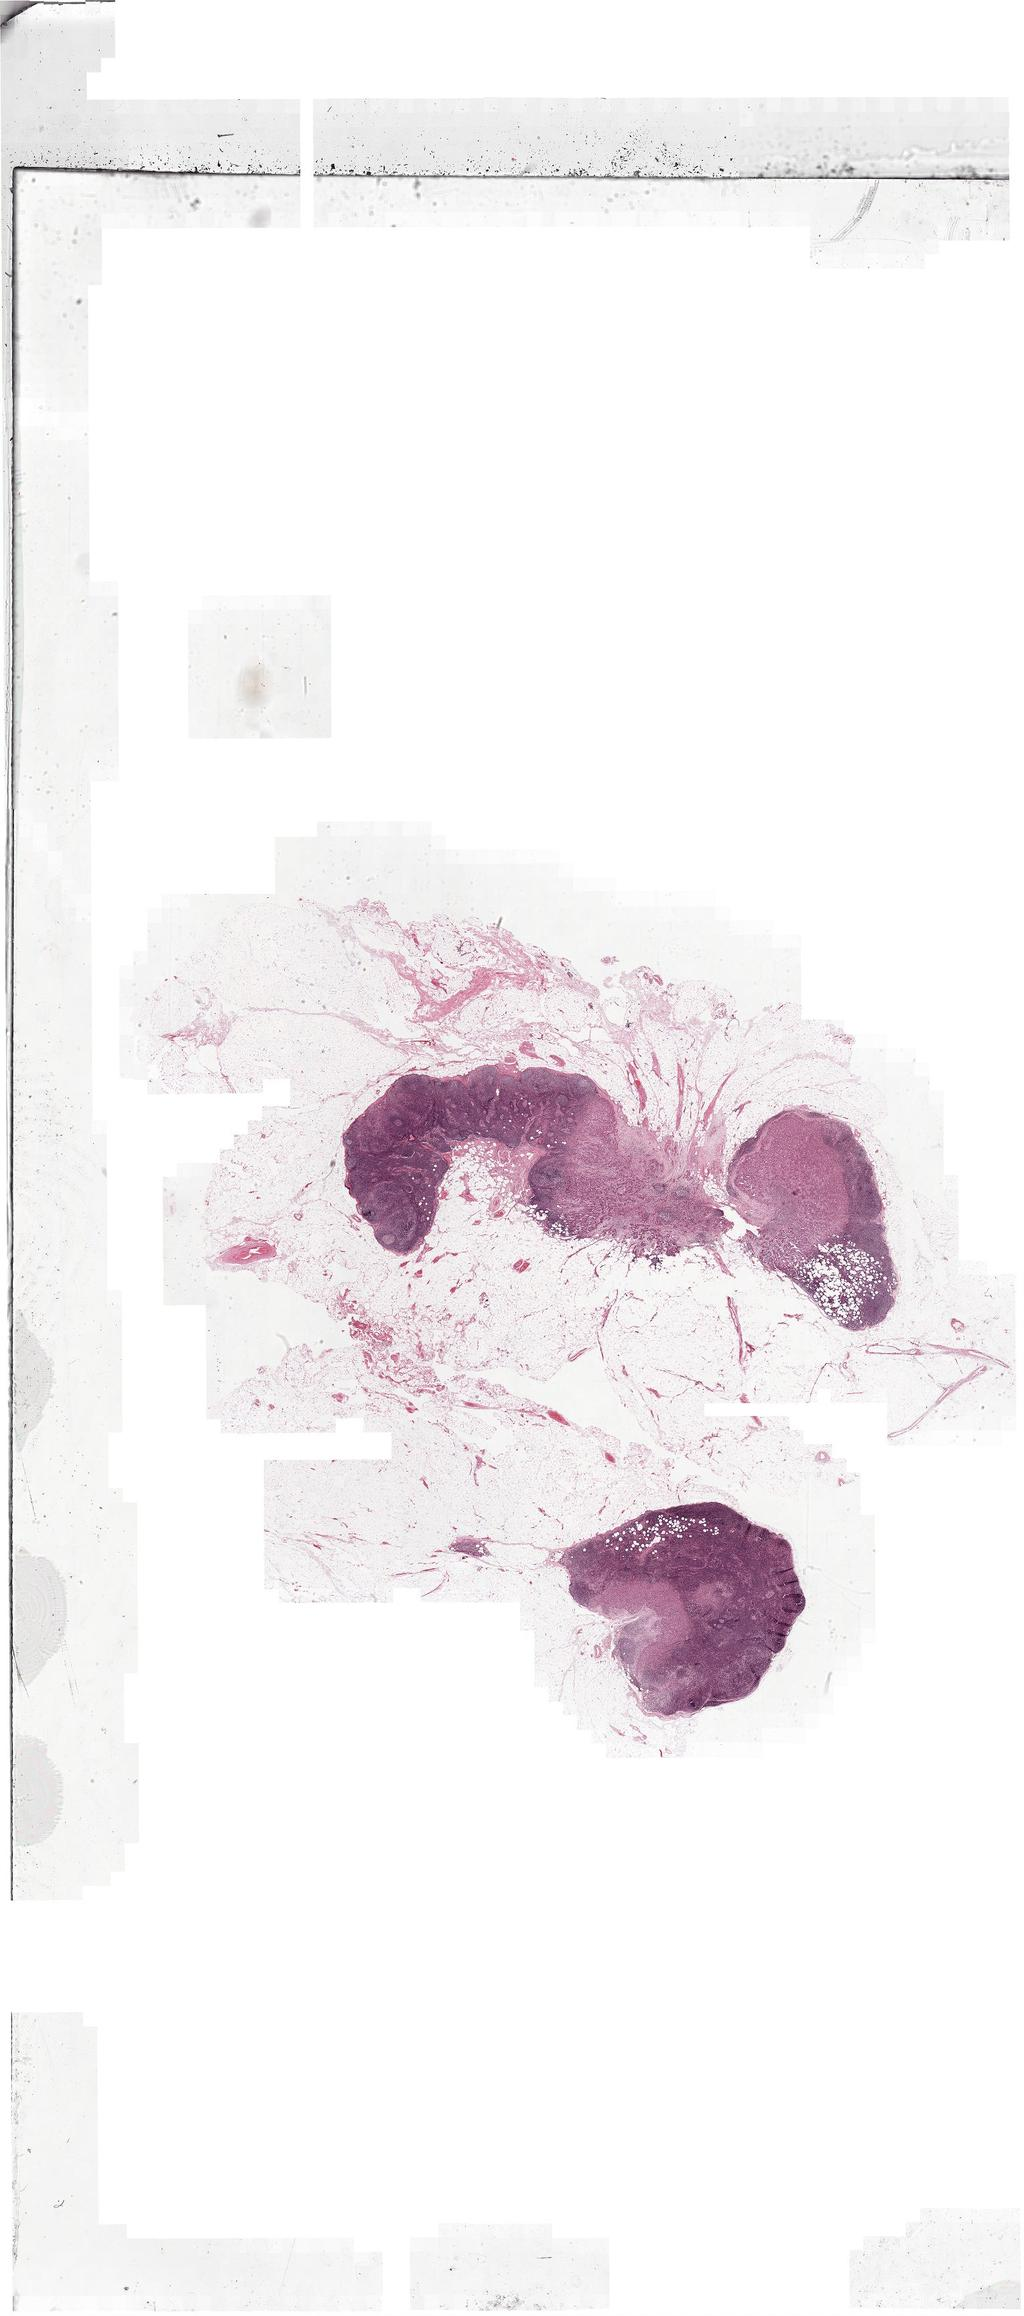


Observation: [(25, 240)]
Thought:

The region_of_interest tool returned a suspicious coordinate at (25, 240) in the thumbnail. I should now pass this coordinate, along with the WSI path, to the zoom tool to get the corresponding zoomed patch images.

Action: zoom
Action Input: {"thumbnail_coords": [(25, 240)], "wsi_path": "/content/drive/My Drive/Colab Notebooks/Dataset/tumor/train/tumor_011.tif"}

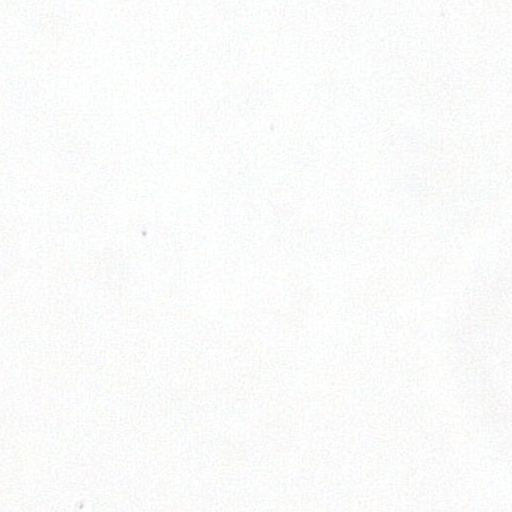


Observation: ['Patch at (2387, 68143)']
Thought:

The zoom tool returned the path to a zoomed patch image corresponding to the suspicious thumbnail coordinate. I should now pass this patch path to the patch_classification tool to check if it contains cancer.

Action: patch_classification
Action Input: ['Patch at (2387, 68143)'] 
Observation: {'Patch at (2387, 68143)': 'likely cancer'}
Thought:

The patch_classification tool indicates that the patch at (2387, 68143), which corresponds to the suspicious region identified in the thumbnail, likely contains cancer.

I have now completed the analysis steps:
1. Used region_of_interest to find a suspicious coordinate in the thumbnail 
2. Used zoom to get the full resolution patch image for that coordinate
3. Used patch_classification to determine that the patch likely contains cancer

Based on these results, I can provide a final answer to the original question.

Final Answer: Based on analyzing the whole slide image tumor_011.tif using the provided tools, a region of the slide located at (2387, 68143) likely contains cancerous tissue. The thumbnail coordinate (25, 240) was identified as suspicious, and the corresponding zoomed patch was classified as "likely cancer" by the patch_classification tool.

> Finished chain.
Based on analyzing the whole slide image tumor_011.tif using the provided tools, a region of the slide located at (2

In [ ]:
from pathlib import Path

dataset_folder_path = "/content/drive/My Drive/Colab Notebooks/Dataset"

tumor_110_thumbnail = str(Path(dataset_folder_path) / "thumbnails" / "tumor_011.jpg")
tumor_110_WSI = str(Path(dataset_folder_path) / "tumor/train" / "tumor_011.tif")

query = f"""
Analyze the slide for cancer.
The thumbnail is located at: {tumor_110_thumbnail}
The WSI is located at: {tumor_110_WSI}
Use the region_of_interest tool to find suspicious areas (output: list of [x, y] coordinates),
then pass that to the zoom tool along with the WSI path as:

{{"thumbnail_coords": [...], "wsi_path": "..."}}

Finally, use patch_classification to check the patches for cancer.
"""

response = agent.run(query)
print(response)
